## **Fundamentos de Analitica II**
### **Asignación:** Comparación de métodos de pronósticos simples de suavización para series de tiempo


Información relevante: Se trabaja con un pequeño dataset con datos de empleo. Y se explora la variable "Ocupados" en miles de personas.

### **1. Cargue de librerias principales**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose # Para gráficas de descomposición de componentes de la serie de tiempo
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # Holt-Winters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holt-Winters Doble y Triple
from sklearn.metrics import mean_squared_error

In [26]:
# Pre-ajustes de diseño
sns.set_style("whitegrid")

### **2. Cargue de datos**

In [86]:
df = pd.read_excel("Data/datosEmpleo.xlsx", index_col="mes", date_parser="mes")
df.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [89]:
# Rango de datos
print(f"Inicio: {min(df.index)}. Fin: {max(df.index)}")

Inicio: 2001-01-01 00:00:00. Fin: 2019-04-01 00:00:00


Shape:  (220, 4)


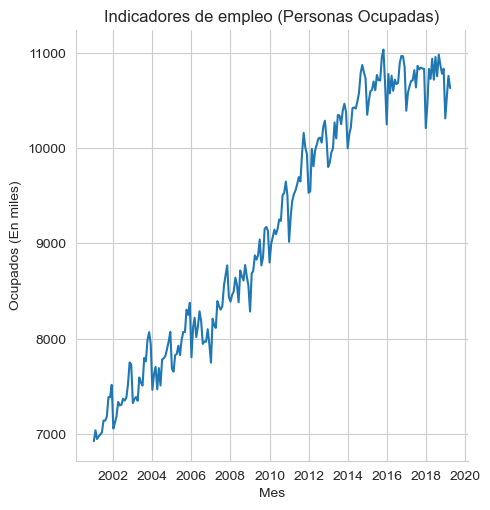

In [45]:
# Exploración de serie temporal
print("Shape: ", df.shape)
sns.relplot(data = df, x = "mes", y = "Ocupados", kind = "line")
plt.ylabel("Ocupados (En miles)")
plt.xlabel("Mes")
plt.title("Indicadores de empleo (Personas Ocupadas)")
plt.show()

### **3. Descomponiendo la serie**

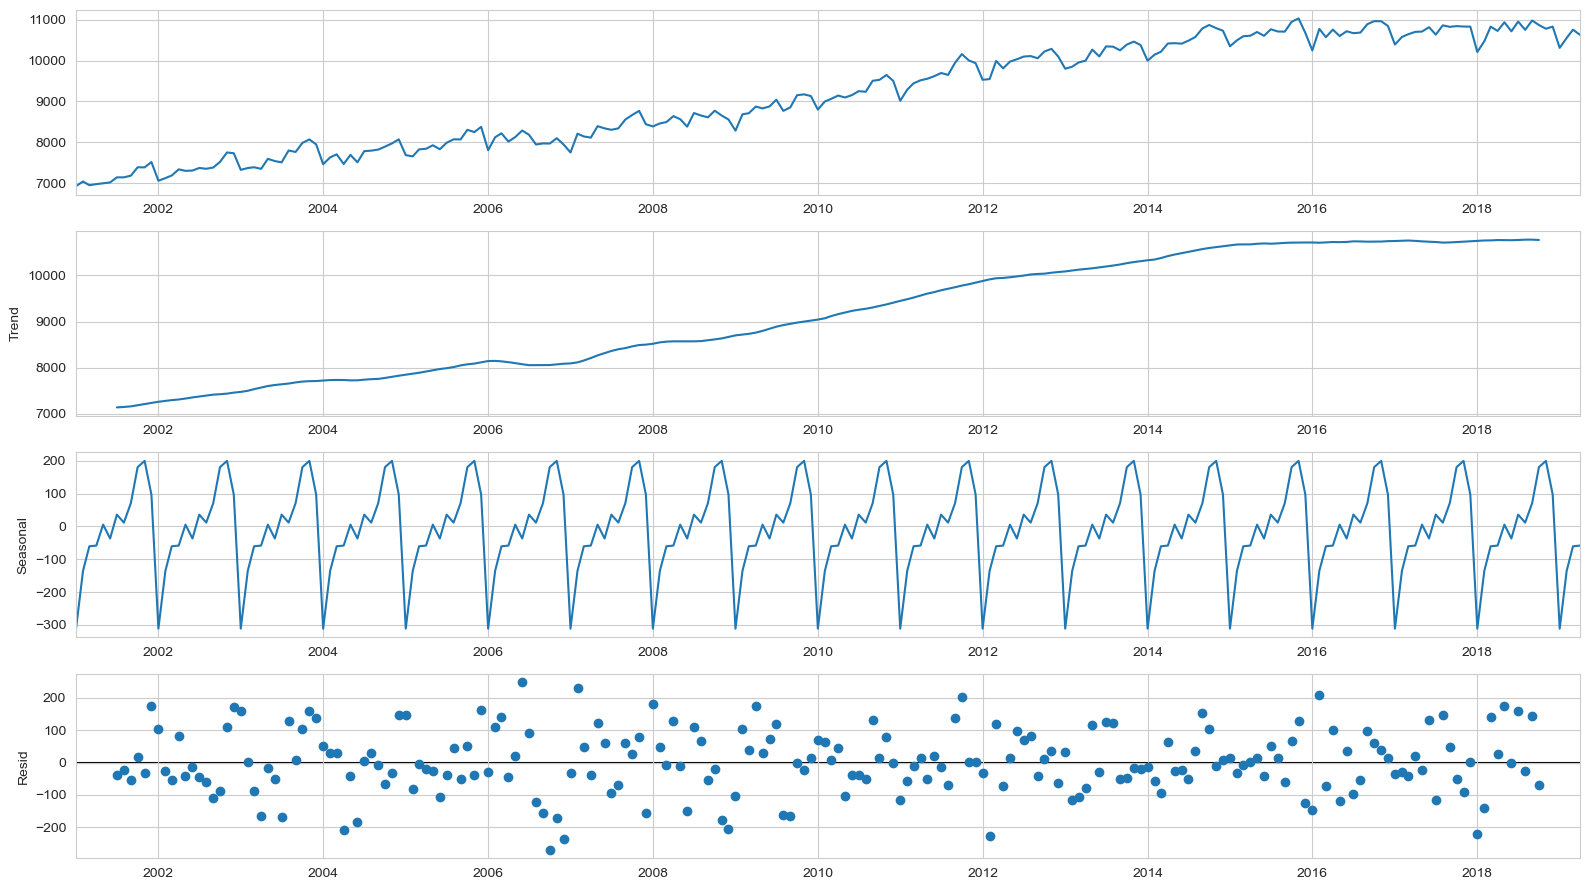

In [48]:
# Se descompone la serie en sus componentes principales: Tendencia, Estacionalidad, y Componente Puramente Aleatorio.

components = seasonal_decompose(df[["Ocupados"]], model = "additive")
figure = components.plot()
figure.set_size_inches((16,9))
figure.tight_layout()
plt.show()

In [49]:
# Extracción númerica de los componentes
components_seasonal = components.seasonal
components_trend = components.trend
components_resid = components.resid

C:\Windows\Temp\ipykernel_19712\1954322673.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


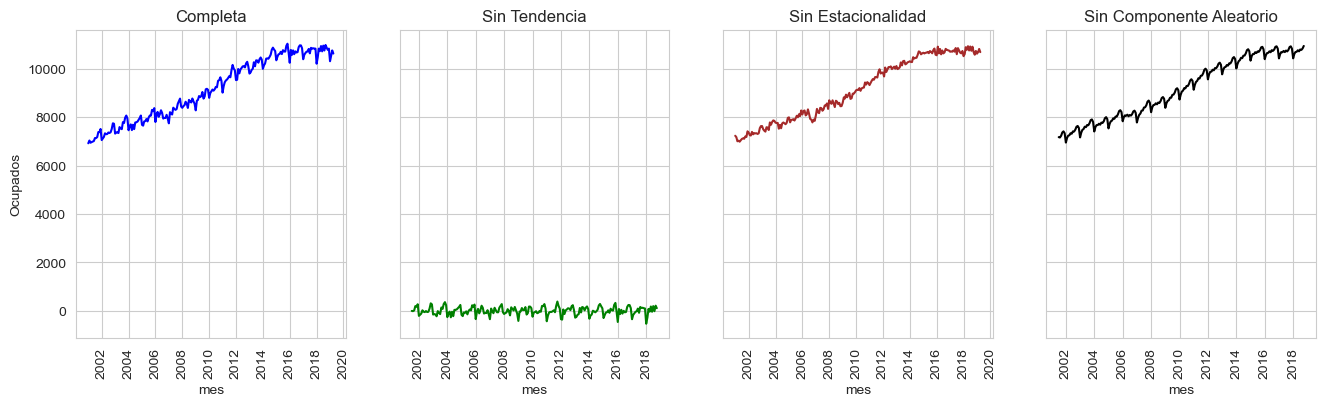

In [93]:
# Visualización de afectación de componentes
df['oc_out_trend'] = df['Ocupados'] - components_trend
df['oc_out_seasonal'] = df['Ocupados'] - components_seasonal
df['oc_out_resid'] = df['Ocupados'] - components_resid


fig, axs = plt.subplots(1,4, figsize = (16,4), sharey = True)
sns.lineplot(x = "mes", y = "Ocupados", data = df, ax = axs[0], color = "blue")
axs[0].set_title("Completa")
sns.lineplot(x = "mes", y = "oc_out_trend", data = df, ax = axs[1], color = "green")
axs[1].set_title("Sin Tendencia")
sns.lineplot(x = "mes", y = "oc_out_seasonal", data = df, ax = axs[2], color = "brown")
axs[2].set_title("Sin Estacionalidad")
sns.lineplot(x = "mes", y = "oc_out_resid", data = df, ax = axs[3], color = "black")
axs[3].set_title("Sin Componente Aleatorio")

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()


### **4. Aplicación de métodos de suavización**

Dataset de entrenamiento:
 Inicio 2001-01-01 00:00:00, Fin 2018-04-01 00:00:00
Dataset de prueba:
 Inicio 2001-01-01 00:00:00, Fin 2018-04-01 00:00:00


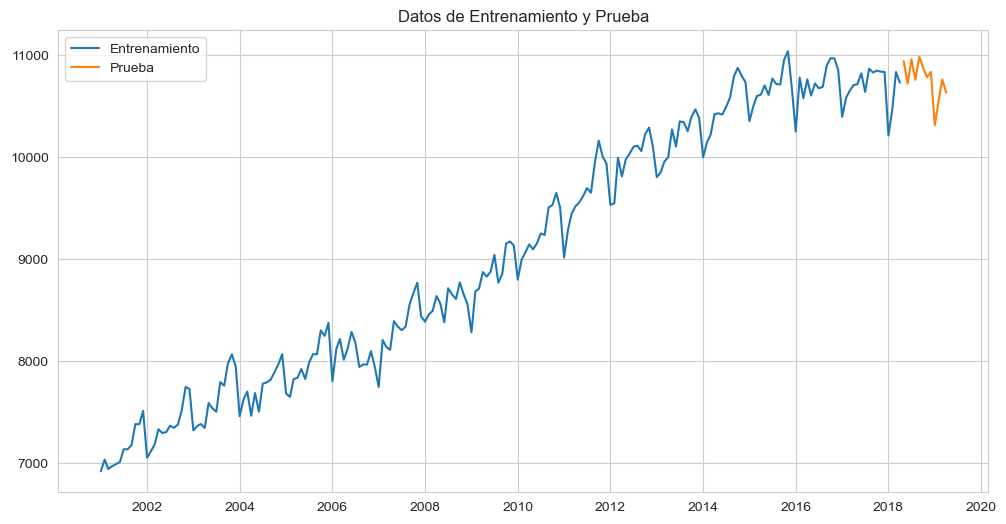

In [101]:
# Separación de datos de entrenamiento
train_len = df.shape[0] - 12 # Menos 1 año
train_oc = df[['Ocupados']][:train_len]
test_oc = df[['Ocupados']][train_len:]

# Check
print(f"Dataset de entrenamiento:\n Inicio {min(train_oc.index)}, Fin {max(train_oc.index)}")
print(f"Dataset de prueba:\n Inicio {min(train_oc.index)}, Fin {max(train_oc.index)}")

fig  = plt.figure(figsize=(12,6))
plt.plot(train_oc, label = "Entrenamiento")
plt.plot(test_oc, label = "Prueba")
plt.title("Datos de Entrenamiento y Prueba")
plt.legend()
plt.show()

### 4.1. Promedio móvil

Formulación:

$$ F_{t + 1}=\frac{Y_{t} + Y_{t-1} + Y_{t-(k-1)} }{ k} $$

Dónde,

$Y_{t}$ = Observación en el período t

$F_{t}$ = Pronóstico en el período t

${k}$ = Número de periodos móviles históricos a considerar